## Homework 2

### 1.
Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both `Bachelor semestre 1` and `Bachelor semestre 6`. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [2]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import scipy
import numpy as np

%matplotlib inline

In [3]:
#ISA base url. This is the page that displays the form
isa_base_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'

#list of ID of academic periods, starting from 2007-2008
academic_periods = [978181, 978187, 978195, 39486325, 123455150, 123456101, 213637754, 213637922, 213638028, 355925344]

#list of ID of semesters (only for bachelor, starting at 1)
#semesters = [249108, 249114, 942155, 942163, 942120, 942175]
semesters = [249108, 942120, 942175]

params_dict = {'ww_x_GPS': -1,
               'ww_i_reportmodel': 133685247,
               'ww_i_reportModelXsl': 133685270,
               'ww_x_UNITE_ACAD': 249847,
               'ww_x_PERIODE_ACAD': 978181,
               'ww_x_PERIODE_PEDAGO': 249108,
               'ww_x_HIVERETE': 'null',
               }
data = {'Sciper': [], 'Civilite': [], 'Nom': [], 'BA1' : [],'BA5' : [],'BA6' : [],}
for current_year in academic_periods :
    params_dict['ww_x_PERIODE_ACAD'] = current_year
    for current_semester in semesters :
        params_dict['ww_x_PERIODE_PEDAGO'] = current_semester

        resp = requests.get(isa_base_url, params=params_dict)
        data_list = resp.text
        soup = BeautifulSoup(data_list, 'html.parser')
        table = soup.findAll('table')[0]
        rows = table.findAll('tr')[2:]
        year = table.findAll('tr')[0].findAll('th')[0].get_text()[14:23]
        bachelor_year = table.findAll('tr')[0].findAll('th')[0].get_text()[43]
        for row in rows:
            cols = row.findAll('td')
            data['Sciper'].append(int(cols[10].get_text()))
            data['Civilite'].append(cols[0].get_text())
            data['Nom'].append(cols[1].get_text())
            data['BA' + bachelor_year].append(year)
            if (bachelor_year is "1"):
                data['BA5'].append(None)    
                data['BA6'].append(None)
            elif (bachelor_year is "5"):
                data['BA1'].append(None)    
                data['BA6'].append(None)
            elif (bachelor_year is "6"):
                data['BA1'].append(None)    
                data['BA5'].append(None)
    
df = pd.DataFrame(data)
df.sort_values(['Sciper','Nom'], inplace=True)
df = df.set_index(['Sciper', 'Nom'])

for sciper in df.index.levels[0]:
    subframe = df.loc[sciper]
    if subframe['BA1'].isnull().values.all() or subframe['BA5'].isnull().values.all() or subframe['BA6'].isnull().values.all():
        df = df.drop(sciper, level=0)

In [4]:

for sciper in df.index.levels[0]:
    subframe = df.loc[sciper]
    if subframe['BA1'].isnull().values.all() or subframe['BA6'].isnull().values.all():
        df = df.drop(sciper, level=0)
        
        
df = df.reset_index().set_index(['Sciper', 'Nom'])

In [5]:
year = []
sciper = []
Name = []
civilite = []
for s, n in df.index:
    subframe = df.loc[s]
    sciper.append(s)
    Name.append(n)
    civilite.append(subframe['Civilite'].values[0])
    
    
    minBA1 = subframe['BA1'][subframe['BA1'].notnull()].values.min()
    maxBA5 = subframe['BA5'][subframe['BA5'].notnull()].values.max()
    maxBA6 = subframe['BA6'][subframe['BA6'].notnull()].values.max()
    
    if maxBA5 > maxBA6:
        maxBA = maxBA5
        semesterMax = 0.5
    else: 
        maxBA = maxBA6
        semesterMax = 1
        
    minBA = int(minBA1[:4])
    maxBA = int(maxBA[:4]) + semesterMax
    
    year.append(maxBA - minBA)
    
result = pd.DataFrame({'Sciper': sciper, 'Name': Name, 'Civilite': civilite, 'Duration': year})
result = result.drop_duplicates()
result = result.set_index(['Sciper'])
result.sort_values('Duration')
    
    
    

,Civilite,Duration,Name
Sciper,,,
147008,Monsieur,3.0,Good Xavier
217629,Monsieur,3.0,Kellenberger Lukas Andreas
217612,Monsieur,3.0,Bottinelli Rémi
217530,Monsieur,3.0,Lauro Raffaele
217469,Monsieur,3.0,Sikiaridis Alexandre Jean Denis
217393,Monsieur,3.0,Plancherel Nicolas Bernard Lucien
217389,Monsieur,3.0,Hubacher Nicolas Daniel
217632,Monsieur,3.0,Gilgien David Yann
217301,Madame,3.0,Pignat Eliéva Arlette


In [6]:
result.groupby(['Civilite', 'Duration']).count()

Name
Civilite Duration      
Madame   3.0         20
         3.5          1
         4.0          4
         4.5          3
         5.5          1
Monsieur 3.0        203
         3.5         35
         4.0         68
         4.5         23
         5.0         22
         5.5         10
         6.0          6
         7.0          1

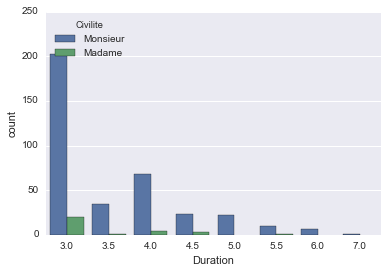

In [17]:
resultMen = result[result['Civilite'] == 'Monsieur']
resultWomen = result[result['Civilite'] == 'Madame']

sns.countplot(result['Duration'], hue=result['Civilite'])

/Users/Thomas/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


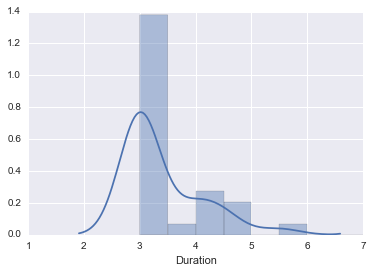

In [8]:
sns.distplot(resultWomen['Duration'], [3,3.5,4,4.5,5,5.5,6,6.5,7])

In [9]:
print(scipy.stats.kstest(resultMen['Duration'], 'poisson', args=(3,)))

KstestResult(statistic=0.64723188878223126, pvalue=0.0)


## 2. 